<a href="https://colab.research.google.com/github/changyui/changyui/blob/main/ResNet_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터셋 불러오기

In [ ]:
import torch
import torch.nn as nn
from torch import cuda
import torch.nn.functional as F
from torch import optim
# import torchvision
# from torchvision import transforms      # 이미지 데이터 transform
from torch.utils.data import TensorDataset, DataLoader, random_split     # 이미지 데이터 로더
import os
import glob # ?

import pickle

import pandas as pd
import numpy as np

In [ ]:

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# torch.manual_seed(777)
# if DEVICE == 'cuda':
  # torch.cuda.manual_seed_all(777)

print(DEVICE)


cuda


In [ ]:
# 경로 지정

# train_path = '/content/drive/MyDrive/파이토치/solo_project/train'
# test_path = '/content/drive/MyDrive/파이토치/solo_project/test'



In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/NMlab/400_5_X.pickle', 'rb') as f:   
    dfx = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/NMlab/400_5_Y.pickle', 'rb') as g:   
    dfy = pickle.load(g)



In [ ]:
type(dfx)

numpy.ndarray

In [ ]:
dfx.shape

(27811, 5, 400, 1)

In [ ]:
x_data = torch.FloatTensor(dfx)
y_data = torch.FloatTensor(dfy)

In [ ]:
type(x_data)

torch.Tensor

In [ ]:
x_data.shape

torch.Size([27811, 5, 400, 1])

**파이토치형 데이터로 전환 : channel 은 맨앞으로** 

In [ ]:
x_data1 = x_data.squeeze()
x_data1.shape

torch.Size([27811, 5, 400])

In [ ]:
x_data2 = x_data1.unsqueeze(1)
x_data2.shape

torch.Size([27811, 1, 5, 400])

In [ ]:
dataset = TensorDataset(x_data2, y_data)

# 2. train set, val set으로 분리 : 비율은 8:2

In [ ]:
len(dataset)

27811

In [ ]:
train_set_size = int(len(dataset) * 0.8)
test_set_size = len(dataset) - train_set_size

train_set, test_set = random_split(dataset, [train_set_size, test_set_size])


In [ ]:
BATCH_SIZE =160 

In [ ]:


train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print('data set:', len(dataset))
print('Train data set:', len(train_set))
print('Test data set:', len(test_set))

data set: 27811
Train data set: 22248
Test data set: 5563


# 3. ResNet 구조만들기 

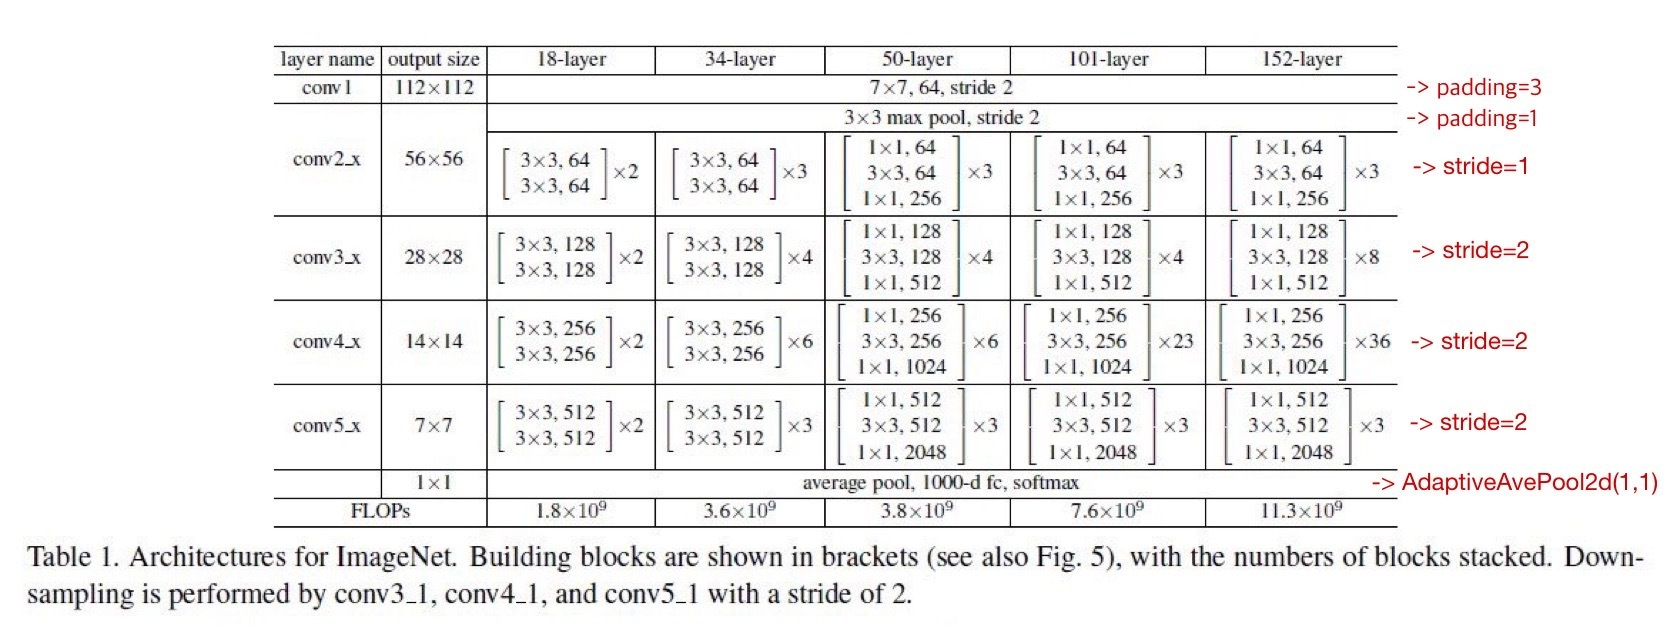

In [ ]:
class block(nn.Module):
    # __init__는 클래스 내의 생성자라 불리고 초기화를 위한 함수이다.
    # self는 인스턴스 자신이다.
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        # super(모델명, self).__init__() 형태로 호출
        # 위처럼 호출해서 nn.Module.__init__()을 실행
        super(block, self).__init__()
        self.expansion = 4 # 확장
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding) 순서로 정의
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        # downsample은 forward시 f(x)+x의 residual을 구현할 경우 f(x)와 x의 텐서사이즈가 다를 때 사용한다.
        self.identity_downsample = identity_downsample
    
    # 네트워크 구조를 정의하는 순방향 함수
    # 여기서는 한가지 입력만 허용하고 있다.
    def forward(self, x):
        # identity에 x 저장
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        # x(=출력값)에 identity 값 더함    
        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module): # resnet50 : [3, 4, 6, 3]
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        # self._make_layer를 이용하여 residual block들을 쌓는다.
        # 필터의 개수는 각 block들을 거치면서 2배씩 늘어난다. (64->128->256->512)
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # (n, 512, 1, 1)의 텐서로 만든다.
        self.fc = nn.Linear(512*4, num_classes) # fully-connected layer
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1) # send it into the fully connected layer
        x = self.fc(x)
        return x
    
    # _make_layer에서 residual block 생성
    # block : 앞에 정의한 block 클래스
    # num_residual_blocks : layer 반복해서 쌓는 개수
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []
        
        # downsampling이 필요한 경우 identity_downsample 생성
            # 1. stride가 1이 아닐 때
            # 2. self.in_channels가 out_channels*4와 크기가 맞지 않을 때
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels*4))
        
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels*4 # 256
        
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels)) # 256 -> 64, 64*4 (256) again
        
        return nn.Sequential(*layers)

In [ ]:
# ResNet50 모델을 device에 만들기

print(DEVICE)
model_resnet50 = ResNet(block, [3, 4, 6, 3], 1, 6).to(DEVICE)
model = model_resnet50

cuda


# 3. 출력 tensor가 맞는지 확인



In [ ]:
from torchsummary import summary
summary(model_resnet50, input_size=(1, 5, 400), device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 3, 200]           3,200
       BatchNorm2d-2           [-1, 64, 3, 200]             128
              ReLU-3           [-1, 64, 3, 200]               0
         MaxPool2d-4           [-1, 64, 2, 100]               0
            Conv2d-5           [-1, 64, 2, 100]           4,160
       BatchNorm2d-6           [-1, 64, 2, 100]             128
              ReLU-7           [-1, 64, 2, 100]               0
            Conv2d-8           [-1, 64, 2, 100]          36,928
       BatchNorm2d-9           [-1, 64, 2, 100]             128
             ReLU-10           [-1, 64, 2, 100]               0
           Conv2d-11          [-1, 256, 2, 100]          16,640
      BatchNorm2d-12          [-1, 256, 2, 100]             512
           Conv2d-13          [-1, 256, 2, 100]          16,640
      BatchNorm2d-14          [-1, 256,

# 4. 훈련하고 평가(초기)

In [ ]:
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

    print("Training End")

In [ ]:
from tqdm import tqdm
import time

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():

     #   for ii in  tqdm(range(100), desc="Process "):
            for data, target in test_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                        
                # 배치 오차를 합산
                test_loss += F.cross_entropy(output, target, reduction='sum').item()
 
                # 가장 높은 값을 가진 인덱스가 바로 예측값
                predicted = output.max(1, keepdim=True)[1]
                # predicted = torch.max(, dim=1)

                label = torch.max(target, dim=1)[1]   
                predicted = predicted.squeeze()
                correct += (label == predicted).sum().item()
     #      time.sleep(0.1)

    test_loss /= len(test_loader.dataset)   
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy

In [ ]:
EPOCHS = 1

for epoch in range(1, EPOCHS+1):
    # 에포크 동안 훈련하기  
    train(model, train_loader, optimizer, epoch)
    print('End of the {} EPOCHS training process'.format(epoch))

    # 평가하기
    test_loss, test_accuracy = evaluate(model, test_loader)

print('[ {} epoch ] Test Loss: {:.4f}, \t Accuracy: {:.2f}% \n'.format(epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/22248 (0%)]	Loss: 0.772967
Train Epoch: 1 [3200/22248 (14%)]	Loss: 0.491903
Train Epoch: 1 [6400/22248 (29%)]	Loss: 0.507379
Train Epoch: 1 [9600/22248 (43%)]	Loss: 0.286003
Train Epoch: 1 [12800/22248 (57%)]	Loss: 0.421385
Train Epoch: 1 [16000/22248 (71%)]	Loss: 0.295497
Train Epoch: 1 [19200/22248 (86%)]	Loss: 0.401024
Training End
End of the 1 EPOCHS training process
[ 1 epoch ] Test Loss: 4.1738, 	 Accuracy: 60.17% 

